<h1> Predicting Successful Goals in Stock Purchasing</h1>

**Details**: This project was done for the DATA 240 - Data Mining course at San Jose State University. The project goal was to utilize data mining, feature generation, and feature reduction techniques. All code below is my own individual work.

**Goal**: Instead of framing the problem as a traditional numerical prediction problem, this approach will also reframe the problem as a binary "Buy" and "Don't Buy" problem that can be modified by the user. The metrics of a successful "Buy" outcome is if the price will raise by x% in n days. Where x is the percent increase of the price and n is the time limit where that increase of price can be reached. The purpose of this method is to appeal to the commercial investor where constant monitoring may not be an option or there is too much uncertainty with attempting to maximize profits.

**Purpose**: The purpose of this notebook is to reimagine the use of machine learning to predict stock prices. In this different approach, the model will be trained on a single stock and data mining will be utilized to attempt to maximize financial gains and minimize risk. This could be useful for investors who want a chance to successfully complete a sell limit order which will sell stock once a certain price is reached. All functions are designed in a linear fashion to accept a dataset input followed by desired time span, profits, and risk. Once inputs are set, prediction accuracy is provided with the option to input prices for a current prediction.

**Dataset**: https://finance.yahoo.com/quote/TSLA?p=TSLA&.tsrc=fin-srch

**Dataset Description**: The dataset being trained on is the TSLA stock prices from 6/29/21 to 10/22/21 with the prediction dataset spanning from **DATE HERE** to 11/19/21. The dataset was manually downloaded from Yahoo as a test, but an API that grabs data in a similar fashion could be more effective in utilizing this notebook for active investing. Otherwise, the Yahoo dataset provides a selection of information including open, high, low, close prices, as well as adjusted close price and trade volume.

### 1. Import Libraries and Settings

In [1]:
# Pandas and numpy for data manipulation and organization
import pandas as pd
import numpy as np

# Remove column display limit and disallow chained assignments
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None 

# Import for plotting visualizations
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns

# sklearn libraries for machine learning and feature importance
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# sklearn libraries for accuracy metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import roc_curve

### 2. Import Data

**Input values here**

In [2]:
# File name of the data you wish to test
filename = "TSLA.csv"

# File name for the data you wish to predict on
# The file will predict the latest csv values with at least 40 previous entries to compute moving averages
test_file = "TSLA Predict.csv"

# The minimum precision you wish to achieve where a higher value decreases the amount of potential losses
precision_min = .9

# The number of days you wish to complete the goal (or how long until an x% increase in price)
n = 21

# The percent value of increase you wish to achieve
p_inc = .1

In [3]:
def data_prep(filename):
    """
    filename: The input file name to find the average price
    
    output: A dataframe that includes the average price column
    """
    
    df = pd.read_csv(filename)
    df['Day'] = df.index + 1
    df["Average"] = (df["High"] + df["Low"]) / 2
    return df

In [4]:
df = data_prep(filename)

df_average = df[["Day", "Average"]]
df_average = df_average.rename(columns={"Average": "Price"})

### 3. Feature Generation

The goal of feature generation is to capture the time-series nature of the data by creating moving averages and changes over time within the data. After these features are generated, feature reduction techiques will occur to determine the most valuable features.

In [5]:
def feature_generation(df, x, p_inc, normalization = True, prediction = False):
    """
    df: The input dataframe with the column Price
    x : The number of days in the future we want to check a certain percent increase
    p_inc: The percent increase we want to check for within x days
    
    Output: A dataframe with additional features.
    
    Note: This will decrease the number of rows in the dataframe by 40 + x since we use moving averages.
    """
    
    # Create five columns that capture moving average prices for different windows
    df['3MA'] = df["Price"].rolling(window=3).mean()
    df['7MA'] = df["Price"].rolling(window=7).mean()
    df['15MA'] = df["Price"].rolling(window=15).mean()
    df['25MA'] = df["Price"].rolling(window=25).mean()
    df['40MA'] = df["Price"].rolling(window=40).mean()

    # Create four columns that capture mininum price for different windows
    df['3MIN'] = df["Price"].rolling(window=3).min()
    df['7MIN'] = df["Price"].rolling(window=7).min()
    df['15MIN'] = df["Price"].rolling(window=15).min()
    df['25MIN'] = df["Price"].rolling(window=25).min()

    # Create four columns that capture max price for different windows
    df['3MAX'] = df["Price"].rolling(window=3).max()
    df['7MAX'] = df["Price"].rolling(window=7).max()
    df['15MAX'] = df["Price"].rolling(window=15).max()
    df['25MAX'] = df["Price"].rolling(window=25).max()
    
    # Normalizes the price between the highs and lows of four different ranges
    df['3Range'] = (df["Price"] - df["Price"].rolling(window=3).min()) / (df["Price"].rolling(window=3).max() - df["Price"].rolling(window=3).min())
    df['7Range'] = (df["Price"] - df["Price"].rolling(window=7).min()) / (df["Price"].rolling(window=7).max() - df["Price"].rolling(window=7).min())
    df['15Range'] = (df["Price"] - df["Price"].rolling(window=15).min()) / (df["Price"].rolling(window=15).max() - df["Price"].rolling(window=15).min())
    df['25Range'] = (df["Price"] - df["Price"].rolling(window=25).min()) / (df["Price"].rolling(window=25).max() - df["Price"].rolling(window=25).min())
    
    # Four columns that measure the exponential moving averages
    df['3EMA'] = df['Price'].ewm(span=3, adjust=False).mean()
    df['7EMA'] = df['Price'].ewm(span=7, adjust=False).mean()
    df['15EMA'] = df['Price'].ewm(span=15, adjust=False).mean()
    df['25EMA'] = df['Price'].ewm(span=25, adjust=False).mean()
    
    # The 40 minus 7 day moving average values
    df['40-7MA'] = df["Price"].rolling(window=39).mean() - df["Price"].rolling(window=7).mean()
    df['40-7EMA'] = df['Price'].ewm(span=39, adjust=False).mean() - df['Price'].ewm(span=7, adjust=False).mean()
    
    # For calculating 10 day momentum
    momentum_list = [0] * 10
    for i in range(10, df.shape[0]):
        momentum_list.append(df['Price'].iloc[i] - df['Price'].iloc[i - 10])
    df['Momentum'] = momentum_list
    
    # For calculating the RSI column where U is the price difference when changes are positive, and D is that absolute value if changes are negative
    rsi_U_list = [0, 0]
    rsi_D_list = [0, 0]
    
        # Calculates the difference for U and D values while ensuring zero values for wrong direction changes
    for i in range(2, df.shape[0]):
        if df['Price'].iloc[i - 1] < df['Price'].iloc[i]:
            rsi_U_list.append(df['Price'].iloc[i] - df['Price'].iloc[i - 1])
            rsi_D_list.append(0)
        else:
            rsi_U_list.append(0)
            rsi_D_list.append(df['Price'].iloc[i-1] - df['Price'].iloc[i])
            
        # Creating the RSI value using the rsi U and rsi D lists from above
    df["U"] = rsi_U_list
    df["D"] = rsi_D_list
    df['UEMA'] = df['U'].ewm(span=14, adjust=False).mean()
    df['DEMA'] = df['D'].ewm(span=14, adjust=False).mean()
    df['RS'] = df['UEMA']/df['DEMA']
    df['RSI'] = 100 - (100 / (1 + df['RS']))
    
        # Drop the columns used to calculate RSI
    df.drop(columns=['U', 'D', 'UEMA', 'DEMA', 'RS'], axis=1, inplace = True)
    
    # Calculating MACD
    df['MACD_temp1'] = df['Price'].ewm(span=26, adjust=False).mean() - df['Price'].ewm(span=12, adjust=False).mean()
    df['MACD_temp2'] = df['MACD_temp1'].ewm(span=9, adjust=False).mean()
    df['MACD'] = df['MACD_temp2'] - df['MACD_temp1']
    df.drop(columns=['MACD_temp1', 'MACD_temp2'], axis=1, inplace = True)
    
    # For calculating a binary moving average crossovers
    ma_crossover_list = [0] * 40
    for i in range(40, df.shape[0]):
        if df['40-7MA'].iloc[i - 1] > 0 and df['40-7MA'].iloc[i] < 0:
            ma_crossover_list.append(1)
        else:
            ma_crossover_list.append(0)
        
    df["MA_Crossover"] = ma_crossover_list
    
    # For calculating a binary exponential moving average crossovers
    e_crossover_list = [0] * 40
    for i in range(40, df.shape[0]):
        if df['40-7EMA'].iloc[i - 1] > 0 and df['40-7EMA'].iloc[i] < 0:
            e_crossover_list.append(1)
        else:
            e_crossover_list.append(0)
        
    df["EMA_Crossover"] = e_crossover_list
    
    # For the binary classification if a price in x days witnesses a p_inc increase
    if prediction == False:
        classification_list = []
        for j in range(0, df.shape[0] - x):
            highest_list = []
            for i in range(j+1, j+x+1):
                highest_list.append(df.iloc[i,1])

            if df.iloc[j,1] * (1 + p_inc) < max(highest_list):
                classification_list.append(1)
            else:
                classification_list.append(0)

        df = df[:-x]
        df["Classification"] = classification_list
    
    df = df.iloc[40: , :]
    
    if normalization == True:
        normalized_df = (df-df.min())/(df.max()-df.min())
        return normalized_df
    else:
        return df

### 4. Feature Reduction

In [6]:
def feature_extraction(df):
    """
    df: The input dataframe that has passed through the feature_generation function
    
    Output: A list of column names that passed feature extraction metrics
    
    Notes: Since each feature generation and reduction is created on different stocks, different methods of
    feature reduction and the features themselves may be different than the stock before. So, this function
    will utilize two feature reduction methods to find different important features for each stock.
    """
    
    # Set y as target variables and X as the features
    y = df_average["Classification"]
    y = y.to_numpy()
    X = df_average.drop(columns=['Day', "Price", "Classification"], axis=1)
    
    # Use train_test_split to split between training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 21, stratify = y)
    
    # Create a logistic regression and fit it to the X and y training sets with y_pred
    logistic = LogisticRegression(solver = "liblinear", random_state=21)
    logistic.fit(X_train, y_train)
    y_pred = logistic.predict(X_test)
    
    # Using the logistic regression create a table of importance results
    X["Intercept"] = 1
    logistic_ml = sm.Logit(y, X)
    logistic_coef = logistic_ml.fit()
    summary_results = logistic_coef.summary2()
    log_results = summary_results.tables[1]
    
    # Create a random forest and fit it to the X and y
    forest = RandomForestClassifier(criterion='entropy', max_depth = 5, n_estimators = 500, random_state = 21)
    forest.fit(X_train, y_train)
    
    importances = forest.feature_importances_

    forest_df = pd.DataFrame({"feature": X_train.columns, "importance": importances})
    forest_df.set_index('feature', inplace=True)
    
    # Combine the results onto the table
    df_results = pd.concat([log_results, forest_df], axis=1, join='inner')
    df_results = df_results[["P>|z|", "importance"]]
    
    # This scoring system utilizes both forms of feature reduction as equally important and assigns a score to each
    df_results.loc[ (df_results["P>|z|"] > .75) & (df_results["P>|z|"] <= 1) , "P>|z|"] = -2
    df_results.loc[ (df_results["P>|z|"] > .5) & (df_results["P>|z|"] <= .75) , "P>|z|"] = -1
    df_results.loc[ (df_results["P>|z|"] > .2) & (df_results["P>|z|"] <= .5) , "P>|z|"] = 0
    df_results.loc[ (df_results["P>|z|"] > .05) & (df_results["P>|z|"] <= .2) , "P>|z|"] = 1
    df_results.loc[ (df_results["P>|z|"] > 0) & (df_results["P>|z|"] <= .05) , "P>|z|"] = 2
    
    df_results.loc[ (df_results["importance"] > .06) & (df_results["importance"] <= 1) , "importance"] = 2
    df_results.loc[ (df_results["importance"] > .05) & (df_results["importance"] <= .06) , "importance"] = 1
    df_results.loc[ (df_results["importance"] > .035) & (df_results["importance"] <= .05) , "importance"] = 0
    df_results.loc[ (df_results["importance"] > .02) & (df_results["importance"] <= .035) , "importance"] = -1
    df_results.loc[ (df_results["importance"] > 0) & (df_results["importance"] <= .02) , "importance"] = -2
    
    df_results['Score'] = df_results["importance"] + df_results["P>|z|"]
    
    # Keep all features with a score of more than or equal to 0
    df_results = df_results[df_results['Score'] >= 0]
    
    # Returns a list of important columns
    return df_results.index.tolist()

### 5. Model Selection and Accuracy

Logistic Regression, Random Forest, and Gaussian Naive Bayes were selected to satisfy the requirement for the project

In [20]:
print("\n**************************** PART ONE: Feature Generation ****************************\n")
df_average = feature_generation(df_average, n, p_inc)

print(f"Number of Valid Days in the Dataset: {len(df_average['Classification'])}")
print(f"Number of Successful Classifications: {int(df_average['Classification'].sum())}")

print("\n**************************** PART TWO: Feature Reduction *****************************\n")
feature_list = feature_extraction(df_average)
print(f"\nImportant Features: {feature_list}")

print("\n**************************** PART THREE: Best Model Locator **************************\n")

# Set y as target variables and X as the features
y = df_average["Classification"]
y = y.to_numpy()
X = df_average[feature_list]

# Use train_test_split to split between training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 21, stratify = y)

# Get accuracy and precision for the Logistic Regression model
logistic = LogisticRegression(solver = "liblinear", random_state=21, C = 100, penalty = 'l1')
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)

log_accuracy = accuracy_score(y_test, y_pred)
log_precision = precision_score(y_test, y_pred)

# Get accuracy and precision for the Random Forest model
forest = RandomForestClassifier(criterion='entropy', max_depth = 18, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 500, random_state = 21)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

random_accuracy = accuracy_score(y_test, y_pred)
random_precision = precision_score(y_test, y_pred)

# Get accuracy and precision for the Gaussian Naive Bayes model
gaussian = GaussianNB(priors = [.7, .3])
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)

gaussiannb_accuracy = accuracy_score(y_test, y_pred)
gaussiannb_precision = precision_score(y_test, y_pred)

# Print accuracy and precision for each model
print(f"Model                                 Accuracy                 Precision")
print(f"Logistic Regression     {log_accuracy:>20.04f}     {log_precision:>20.04f}")
print(f"Random Forest           {random_accuracy:>20.04f}     {random_precision:>20.04f}")
print(f"Gaussian Naive Bayes    {gaussiannb_accuracy:>20.04f}     {gaussiannb_precision:>20.04f}\n")

# Check which model yielded the best results and create predictions based on that model
if max(log_precision, random_precision, gaussiannb_precision) == log_precision:
    print(f"Suggested Model: Logistic Regression")
    best_model = "log"
    preds = logistic.predict_proba(X_test)

elif max(log_precision, random_precision, gaussiannb_precision) == random_precision:
    print(f"Suggested Model: Random Forest")
    best_model = "rf"
    preds = forest.predict_proba(X_test)

else:
    print(f"Suggested Model: Gaussian Naive Bayes")
    best_model = "gnb"
    preds = gaussian.predict_proba(X_test)

# The roc_curve function will create three arrays that holds false and true positive
# rates and their thresholds
fpr, tpr, thresholds = roc_curve(y_test, preds[:, 1])

accuracy_list = []
precision_list = []

# For every value in thresholds, change the probability of a prediction to 0 or 1 
# depending if it is less than that threshold. Then, find the accuracy and precision
# for each of those thresholds
for thres in thresholds:
    y_pred = np.where(preds[:,1] > thres, 1, 0)
    # Apply desired utility function to y_preds, for example accuracy.
    accuracy_list.append(accuracy_score(y_test, y_pred, normalize=True))
    precision_list.append(precision_score(y_test, y_pred, zero_division = 0))

# Default value for best accuracy
best_acc = 0

# Check every threshold again to find the best threshold that yields the best accuracy
# given it has a precision greater than the inputted minimum precision
for i in range(0, len(thresholds)):
    if precision_list[i] >= precision_min and accuracy_list[i] > best_acc:
        best_acc = accuracy_list[i]
        best_thres = []
        best_thres.append(thresholds[i])
        best_thres.append(accuracy_list[i])
        best_thres.append(precision_list[i])

y_pred = np.where(preds[:,1] > best_thres[0], 1, 0)

# Create a confusion matrix and print results of the predictions
conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred),
                    index = ['Actual[0]', 'Actual[1]'],
                    columns = ['Predict[0]', 'Predict[1]'])

print("\n**************************** PART FOUR: Best Cutoff ******************************\n")

print(f"Confusion Matrix for Minimum Precision of {precision_min}\n")
print(conf_mat)

print(f"\nPrecision Achieved: {best_thres[2]:.04f}")
print(f"Accuracy Achieved: {best_thres[1]:.04f}\n")

print("Confusion Matrix Descriptions for Test Data")
print(f"(True Positives)  Number of Successfully Classified Objectives: {conf_mat.iloc[1][1]}")
print(f"(False Positives) Number of Potential Losses: {conf_mat.iloc[0][1]}")
print(f"(False Negatives) Number of Investment Days Missed: {conf_mat.iloc[1][0]}")
print(f"(True Negatives)  Number of Correctly Labelled 'Don't Buy' Days: {conf_mat.iloc[0][0]}")


**************************** PART ONE: Feature Generation ****************************

Number of Valid Days in the Dataset: 2546
Number of Successful Classifications: 1359

**************************** PART TWO: Feature Reduction *****************************

         Current function value: 0.652615
         Iterations: 35


C:\Users\altho\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Important Features: ['3MA', '15MA', '25MA', '40MA', '7MIN', '15MIN', '25MIN', '15MAX', '15Range', '25Range', '3EMA', '15EMA', '25EMA', '40-7EMA']

**************************** PART THREE: Best Model Locator **************************



C:\Users\altho\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model                                 Accuracy                 Precision
Logistic Regression                   0.5824                   0.5782
Random Forest                         0.9118                   0.9158
Gaussian Naive Bayes                  0.5078                   0.5228

Suggested Model: Random Forest

**************************** PART FOUR: Best Cutoff ******************************

Confusion Matrix for Minimum Precision of 0.9

           Predict[0]  Predict[1]
Actual[0]         216          22
Actual[1]          22         250

Precision Achieved: 0.9191
Accuracy Achieved: 0.9137

Confusion Matrix Descriptions for Test Data
(True Positives)  Number of Successfully Classified Objectives: 250
(False Positives) Number of Potential Losses: 22
(False Negatives) Number of Investment Days Missed: 22
(True Negatives)  Number of Correctly Labelled 'Don't Buy' Days: 216


### 6. Predicting Values

In [21]:
test_file = "TSLA Predict.csv"

df_predict = data_prep(test_file)

df_predict_average = df_predict[["Day", "Average"]]
df_predict_average = df_predict_average.rename(columns={"Average": "Price"})
df_predict_average = feature_generation(df_predict_average, 21, .1, prediction = True)
df_predict_average = df_predict_average[feature_list]

In [22]:
prediction_percents = []

print(f"For a precision of {best_thres[2]:.04f}, buy on the days that are above a {best_thres[0]:.04f} prediction threshold")

for i in range(0, len(df_predict_average.index)):
    input_pred = df_predict_average.iloc[i].to_numpy()
    
    if best_model == "rf":
        pred_percent = forest.predict_proba(input_pred.reshape(1, -1))[0][1]
    
    elif best_model == "gnb":
        pred_percent = gaussian.predict_proba(input_pred.reshape(1, -1))[0][1]

    elif best_model == "log":
        pred_percent = logistic.predict_proba(input_pred.reshape(1, -1))[0][1]
    
    prediction_percents.append(pred_percent)
    print(f"Date: {df_predict.Date[i]} | Prediction Percent: {pred_percent:.04f} | Cutoff Prediction: {'Buy' if pred_percent > best_thres[0] else 'Do not buy'}")

For a precision of 0.9191, buy on the days that are above a 0.5041 prediction threshold
Date: 2021-08-23 | Prediction Percent: 0.9734 | Cutoff Prediction: Buy
Date: 2021-08-24 | Prediction Percent: 0.7695 | Cutoff Prediction: Buy
Date: 2021-08-25 | Prediction Percent: 0.7198 | Cutoff Prediction: Buy
Date: 2021-08-26 | Prediction Percent: 0.5213 | Cutoff Prediction: Buy
Date: 2021-08-27 | Prediction Percent: 0.6731 | Cutoff Prediction: Buy
Date: 2021-08-30 | Prediction Percent: 0.6361 | Cutoff Prediction: Buy
Date: 2021-08-31 | Prediction Percent: 0.5406 | Cutoff Prediction: Buy
Date: 2021-09-01 | Prediction Percent: 0.3822 | Cutoff Prediction: Do not buy
Date: 2021-09-02 | Prediction Percent: 0.3984 | Cutoff Prediction: Do not buy
Date: 2021-09-03 | Prediction Percent: 0.3233 | Cutoff Prediction: Do not buy
Date: 2021-09-07 | Prediction Percent: 0.4165 | Cutoff Prediction: Do not buy
Date: 2021-09-08 | Prediction Percent: 0.3731 | Cutoff Prediction: Do not buy
Date: 2021-09-09 | Predic

### 7. Additional Data Mining Information

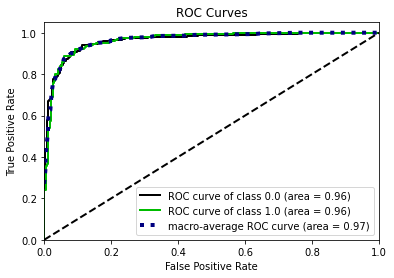

In [28]:
skplt.metrics.plot_roc(y_test, forest.predict_proba(X_test), plot_micro = False)
plt.show()

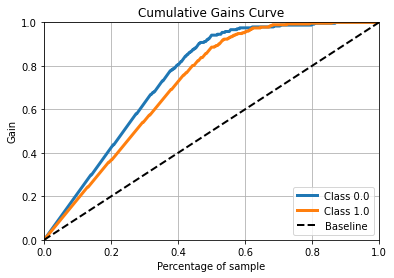

In [29]:
skplt.metrics.plot_cumulative_gain(y_test, forest.predict_proba(X_test))
plt.show()

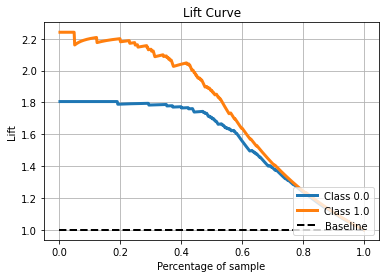

In [24]:
skplt.metrics.plot_lift_curve(y_test, forest.predict_proba(X_test))
plt.show()